In [2]:
import sys, os, time
import numpy as np
%matplotlib notebook
os.environ["CUDA_VISIBLE_DEVICES"]="3"
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as distrib
#from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq import odeint
import gym
import h5py as hf

%load_ext autoreload
%autoreload 2

import foundation as fd
from foundation import util
from foundation import nets
from foundation import train

from nb_backend import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
latent_dim = 4
nhidden = 20
rnn_nhidden = 25
obs_dim = 2
nspiral = 1000
start = 0.
stop = 6 * np.pi
noise_std = .3
a = 0.
b = .3
ntotal = 1000
nsample = 100

niters = 100
lr = 1e-2
device = 'cpu' #torch.device('cuda:0')

In [4]:
orig_trajs, samp_trajs, orig_ts, samp_ts = generate_spiral2d(
        nspiral=nspiral,
        start=start,
        stop=stop,
        noise_std=noise_std,
        a=a, b=b,
        savefig=False
    )
orig_trajs = torch.from_numpy(orig_trajs).float().to(device)
samp_trajs = torch.from_numpy(samp_trajs).float().to(device)
samp_ts = torch.from_numpy(samp_ts).float().to(device)
orig_trajs.shape, samp_trajs.shape, samp_ts.shape

(torch.Size([1000, 500, 2]), torch.Size([1000, 100, 2]), torch.Size([100]))

<IPython.core.display.Javascript object>


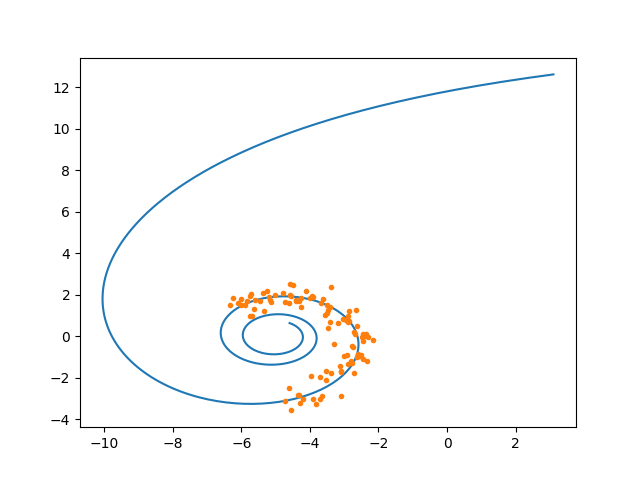

In [5]:
plt.figure()
idx = 12
plt.plot(*orig_trajs[idx].cpu().numpy().T)
plt.plot(*samp_trajs[idx].cpu().numpy().T, ls='', marker='.')

In [6]:
samp_ts

tensor([0.0000, 0.0378, 0.0755, 0.1133, 0.1511, 0.1889, 0.2266, 0.2644, 0.3022,
        0.3400, 0.3777, 0.4155, 0.4533, 0.4911, 0.5288, 0.5666, 0.6044, 0.6422,
        0.6799, 0.7177, 0.7555, 0.7933, 0.8310, 0.8688, 0.9066, 0.9444, 0.9821,
        1.0199, 1.0577, 1.0955, 1.1332, 1.1710, 1.2088, 1.2466, 1.2843, 1.3221,
        1.3599, 1.3977, 1.4354, 1.4732, 1.5110, 1.5488, 1.5865, 1.6243, 1.6621,
        1.6999, 1.7376, 1.7754, 1.8132, 1.8510, 1.8887, 1.9265, 1.9643, 2.0021,
        2.0398, 2.0776, 2.1154, 2.1532, 2.1909, 2.2287, 2.2665, 2.3043, 2.3420,
        2.3798, 2.4176, 2.4554, 2.4931, 2.5309, 2.5687, 2.6065, 2.6442, 2.6820,
        2.7198, 2.7576, 2.7953, 2.8331, 2.8709, 2.9086, 2.9464, 2.9842, 3.0220,
        3.0597, 3.0975, 3.1353, 3.1731, 3.2108, 3.2486, 3.2864, 3.3242, 3.3619,
        3.3997, 3.4375, 3.4753, 3.5130, 3.5508, 3.5886, 3.6264, 3.6641, 3.7019,
        3.7397])

In [9]:
func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim//2, obs_dim, rnn_nhidden, nspiral).to(device)
dec = Decoder(latent_dim, obs_dim, nhidden).to(device)
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
optimizer = torch.optim.Adam(params, lr=lr)
loss_meter = RunningAverageMeter()
print(func)
print(rec)
print(dec)
cnt = list(map(util.count_parameters, [func, rec, dec]))
print(cnt, sum(cnt))

LatentODEfunc(
  (elu): ELU(alpha=1.0, inplace)
  (fc1): Linear(in_features=4, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=4, bias=True)
)
RecognitionRNN(
  (i2h): Linear(in_features=27, out_features=25, bias=True)
  (h2o): Linear(in_features=25, out_features=4, bias=True)
)
Decoder(
  (relu): ReLU(inplace)
  (fc1): Linear(in_features=4, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=2, bias=True)
)
[604, 804, 142] 1550


In [10]:
itr = 0

In [11]:
for _ in range(1):
    optimizer.zero_grad()
    # backward in time to infer q(z_0)
    h = rec.initHidden().to(device)
    for t in reversed(range(samp_trajs.size(1))):
        #h = rec.initHidden().to(device)
        obs = samp_trajs[:, t, :]
        out, h = rec.forward(obs, h)
    print(out.shape, samp_trajs.shape)
    z0 = out

    # forward in time and solve ode for reconstructions
    pred_z = odeint(func, z0, samp_ts).permute(1, 0, 2)
    pred_x = dec(pred_z)

    # compute loss
    loss = F.mse_loss(pred_x, samp_trajs)
    loss.backward()
    optimizer.step()
    loss_meter.update(loss.item())

    print('Iter: {}, running avg elbo: {:.4f}'.format(itr+1, loss_meter.avg))

    itr += 1

torch.Size([1000, 4]) torch.Size([1000, 100, 2])
Iter: 1, running avg elbo: 17.1399


In [25]:
samp_ts

tensor([0.0000, 0.0378, 0.0755, 0.1133, 0.1511, 0.1889, 0.2266, 0.2644, 0.3022,
        0.3400, 0.3777, 0.4155, 0.4533, 0.4911, 0.5288, 0.5666, 0.6044, 0.6422,
        0.6799, 0.7177, 0.7555, 0.7933, 0.8310, 0.8688, 0.9066, 0.9444, 0.9821,
        1.0199, 1.0577, 1.0955, 1.1332, 1.1710, 1.2088, 1.2466, 1.2843, 1.3221,
        1.3599, 1.3977, 1.4354, 1.4732, 1.5110, 1.5488, 1.5865, 1.6243, 1.6621,
        1.6999, 1.7376, 1.7754, 1.8132, 1.8510, 1.8887, 1.9265, 1.9643, 2.0021,
        2.0398, 2.0776, 2.1154, 2.1532, 2.1909, 2.2287, 2.2665, 2.3043, 2.3420,
        2.3798, 2.4176, 2.4554, 2.4931, 2.5309, 2.5687, 2.6065, 2.6442, 2.6820,
        2.7198, 2.7576, 2.7953, 2.8331, 2.8709, 2.9086, 2.9464, 2.9842, 3.0220,
        3.0597, 3.0975, 3.1353, 3.1731, 3.2108, 3.2486, 3.2864, 3.3242, 3.3619,
        3.3997, 3.4375, 3.4753, 3.5130, 3.5508, 3.5886, 3.6264, 3.6641, 3.7019,
        3.7397])

In [35]:
#orig_ts

In [36]:
h = rec.initHidden().to(device)
for t in reversed(range(samp_trajs.size(1))):
    obs = samp_trajs[:, t, :]
    out, h = rec.forward(obs, h)
z0 = out

pred_z = odeint(func, z0, samp_ts).permute(1, 0, 2)
pred_z_adv = odeint(func, z0, torch.tensor(orig_ts)).permute(1, 0, 2)
pred_x = dec(pred_z)
pred_x_adv = dec(pred_z_adv)
print(pred_x.shape, samp_trajs.shape)

torch.Size([1000, 100, 2]) torch.Size([1000, 100, 2])


<IPython.core.display.Javascript object>


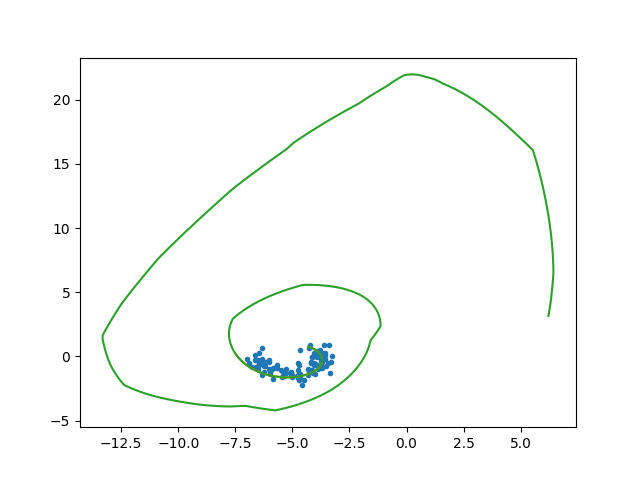

In [48]:
plt.figure()
idx = 52
plt.plot(*samp_trajs[idx].detach().numpy().T, marker='.', ls='')
plt.plot(*pred_x[idx].detach().numpy().T)
plt.plot(*pred_x_adv[idx].detach().numpy().T)

In [66]:
for _ in range(50):
    optimizer.zero_grad()
    # backward in time to infer q(z_0)
    h = rec.initHidden().to(device)
    for t in reversed(range(samp_trajs.size(1))):
        obs = samp_trajs[:, t, :]
        out, h = rec.forward(obs, h)
    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
    qz0 = distrib.Normal(qz0_mean, qz0_logvar.exp())
    #epsilon = torch.randn(qz0_mean.size()).to(device)
    #z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
    z0 = qz0.rsample()
    z0 = qz0_mean

    # forward in time and solve ode for reconstructions
    pred_z = odeint(func, z0, samp_ts).permute(1, 0, 2)
    pred_x = dec(pred_z)

    # compute loss
    noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
    noise_logvar = 2. * torch.log(noise_std_).to(device)
    #logpx = log_normal_pdf(samp_trajs, pred_x, noise_logvar).sum(-1).sum(-1)
    px = distrib.Normal(pred_x, noise_std*torch.ones(*pred_x.size()).to(device))
    logpx = px.log_prob(samp_trajs).sum(-1).sum(-1)
    pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
    analytic_kl = distrib.kl_divergence(qz0, None).sum(-1)
    #loss = torch.mean(-logpx + analytic_kl, dim=0)
    loss = torch.mean(-logpx, dim=0)
    loss.backward()
    optimizer.step()
    loss_meter.update(loss.item())

    print('Iter: {}, running avg elbo: {:.4f} ({:.4f}, {:.4f})'.format(itr, -loss_meter.avg, logpx.mean().item(), analytic_kl.mean().item()))

    itr += 1

Iter: 251, running avg elbo: -3750.1735 (-1110.3778, 47.2872)
Iter: 252, running avg elbo: -3724.0273 (-1135.5553, 47.3258)
Iter: 253, running avg elbo: -3699.0026 (-1221.5549, 46.9470)
Iter: 254, running avg elbo: -3673.6809 (-1166.8347, 47.8430)
Iter: 255, running avg elbo: -3647.6354 (-1069.1289, 47.3045)
Iter: 256, running avg elbo: -3622.0836 (-1092.4508, 46.7585)
Iter: 257, running avg elbo: -3596.9170 (-1105.4261, 47.3424)
Iter: 258, running avg elbo: -3571.6925 (-1074.4669, 47.3365)
Iter: 259, running avg elbo: -3546.2836 (-1030.8079, 46.9118)
Iter: 260, running avg elbo: -3521.2559 (-1043.5061, 46.4785)
Iter: 261, running avg elbo: -3496.9795 (-1093.6207, 46.9546)
Iter: 262, running avg elbo: -3471.9780 (-996.8269, 47.1720)
Iter: 263, running avg elbo: -3447.5570 (-1029.8773, 46.7912)
Iter: 264, running avg elbo: -3423.1760 (-1009.4591, 46.4892)
Iter: 265, running avg elbo: -3398.5041 (-955.9818, 46.3599)
Iter: 266, running avg elbo: -3374.6052 (-1008.6150, 46.5389)
Iter: 267,

In [67]:
h = rec.initHidden().to(device)
for t in reversed(range(samp_trajs.size(1))):
    obs = samp_trajs[:, t, :]
    out, h = rec.forward(obs, h)
qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]

In [98]:
analytic_kl.shape

torch.Size([1000])

<IPython.core.display.Javascript object>


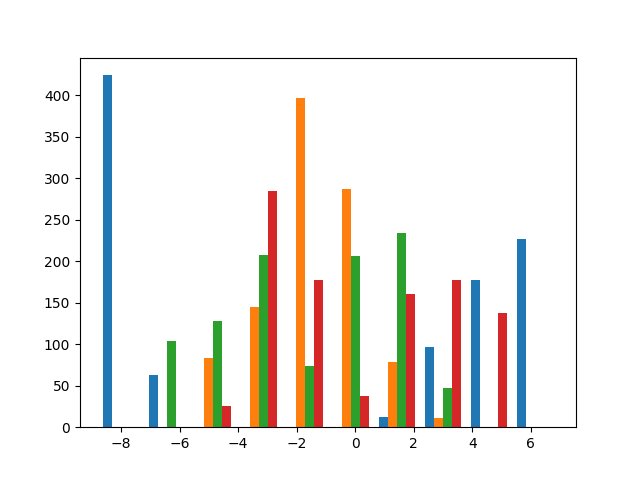

([array([424.,  63.,   0.,   0.,   0.,   0.,  12.,  97., 177., 227.]),
  array([  0.,   0.,  83., 145., 396., 287.,  78.,  11.,   0.,   0.]),
  array([  0., 104., 128., 207.,  74., 206., 234.,  47.,   0.,   0.]),
  array([  0.,   0.,  25., 285., 177.,  38., 160., 177., 138.,   0.])],
 array([-8.791216  , -7.2189283 , -5.646641  , -4.0743527 , -2.5020652 ,
        -0.9297776 ,  0.64251006,  2.2147977 ,  3.7870853 ,  5.359373  ,
         6.9316607 ], dtype=float32),
 <a list of 4 Lists of Patches objects>)

In [99]:
plt.figure()
plt.hist(z0.detach().cpu().numpy())

In [100]:
sample = torch.randn(10, 4).to(device)

In [101]:
z = odeint(func, sample, samp_ts).permute(1, 0, 2)
x = dec(z)
z.shape, x.shape

(torch.Size([10, 100, 4]), torch.Size([10, 100, 2]))

<IPython.core.display.Javascript object>


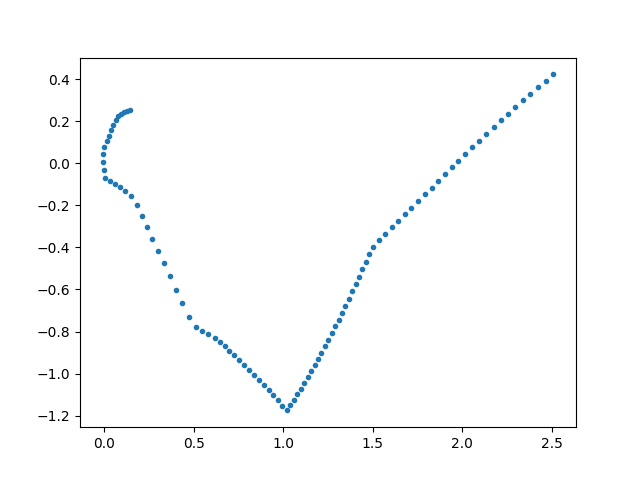

In [103]:
plt.figure()
idx = 4
plt.plot(*x[idx].detach().cpu().numpy().T, ls='', marker='.')